In [109]:
#Import libraries
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from matplotlib import ticker
import itertools
from matplotlib.ticker import FixedLocator, FixedFormatter
from scipy import stats
from sklearn.preprocessing import normalize
from sklearn.preprocessing import minmax_scale

In [2]:
#Ensure reproducibility
random.seed(1)
np.random.seed(1)

In [130]:
class model(object):
    '''
    This class implements the CP model of human vision 
    as described in "Modeling learned categorical perception in human vision"
    Casey and Snowdon (2012)
    '''

    def __init__(self, M_PC=7, M_EC=7, M_VV=7, W_c=0.4, mu_PC=0.6, mu_EC=0.4, mu_VV=0.2, rho=1, eta=0.01):
        
  
        #Activation vectors
        self.f_u_PC = np.zeros(M_PC)                                         #Pre-cortical activity
        self.f_u_EC = np.zeros(M_EC)                                         #Early cortical activity
        self.f_u_VV = np.zeros(M_VV)                                         #Ventral visual activity
        
        #Weights
        self.W_PC = np.random.normal(0, 0.5, 9*M_PC).reshape((9, M_PC))        #Pre-cortical weights
        self.W_EC = np.random.normal(0, 0.5, M_PC*M_EC).reshape((M_PC, M_EC))  #Early visual cortex weights
        self.W_VV = np.random.normal(0, 0.5, M_EC*M_VV).reshape((M_EC, M_VV)) #Ventral visual weights
        self.W_c = W_c                                                         #Category input weight
        
        #Parameters
        self.mu_PC = mu_PC                                                   #Pre-cortical Inhibtion rate
        self.mu_EC = mu_EC                                                   #Early cortical Inhibtion rate
        self.mu_VV = mu_VV                                                   #Ventral visual Inhibtion rate      
        self.eta = eta                                                       #Learning rate                            
        self.rho = rho                                                       #Weight change threshold
      
    def activation(self, x, module, cat_input=0):
        '''
        This function computes the activation of the module specified as an argument and given an input. 
        Cat_input is only 1 when a stimulus belonging to category B is presented AND the model is in category training
        Returns the activation vector.
        Module 0: precortical, module 1:early cortical, module 2:ventral visual
        '''
        if module == 0:
            weights = self.W_PC
            mu = self.mu_PC
        elif module == 1:
            weights = self.W_EC
            mu = self.mu_EC
        else:
            weights = self.W_VV
            mu = self.mu_VV
            
        # Equations 4 and 6
        f_u = np.dot(x, weights)
        
        y_win_i = np.argmax(f_u)
        if not np.isscalar(y_win_i):
            y_win_i = np.random.choice(y_win_i)
        for k in range(len(f_u)):
            if f_u[k] > 1:
                f_u[k] = 1
            elif f_u[k] < 0:
                f_u[k] = 0
        y_win = np.amax(f_u)
        if module == 2:
            f_u += self.W_c*cat_input
        
        # Equation 5
        #y = np.array([fu - mu*y_win if fu < f_u[y_win_i] else fu for fu in f_u ])
        for i in f_u:
            if i < f_u[y_win_i]:
                i -= mu*y_win
                
        if module == 0:
            self.f_u_PC = f_u
        elif module == 1:
            self.f_u_EC = f_u
        else:
            self.f_u_VV = f_u
        
        return f_u
    
    def update(self, x, module, cat_input=0, category_training=False):
        '''
        This function updates the weights of the module specficied as an argument given an input x
        '''
        # Equation 8
        if category_training:
            ar = np.append(x, cat_input)
            mean_x = np.mean(ar)
        else:
            mean_x = np.mean(x)
     
        # Equation 7 
        # Layer 0: precortical, layer 1:early cortical, layer 2:ventral visual
        if module == 0:
            w_ = np.zeros((self.W_PC.shape[0], self.W_PC.shape[1]))
            for i in range(self.W_PC.shape[0]):
                for j in range(self.W_PC.shape[1]):
                    if x[i] > self.rho*mean_x:
                        w_[i, j] = self.W_PC[i,j] + self.eta*x[i]*self.f_u_PC[j]
                    else:
                        w_[i, j] = self.W_PC[i,j]
                        
        elif module == 1:
            w_ = np.zeros((self.W_EC.shape[0], self.W_EC.shape[1]))
            for i in range(self.W_EC.shape[0]):
                for j in range(self.W_EC.shape[1]):
                    if x[i] > self.rho*mean_x:
                        w_[i, j] = self.W_EC[i,j] + self.eta*x[i]*self.f_u_EC[j]
                    else:
                        w_[i, j] = self.W_EC[i,j]
                        
        else:
            w_ = np.zeros((self.W_VV.shape[0], self.W_VV.shape[1]))
            for i in range(self.W_VV.shape[0]):
                for j in range(self.W_VV.shape[1]):
                    if x[i] > self.rho*mean_x:
                        w_[i, j] = self.W_VV[i,j] + self.eta*x[i]*self.f_u_VV[j]
                    else:
                        w_[i, j] = self.W_VV[i,j]
                        
            if category_training:
                w_ = np.concatenate((w_, [np.repeat(self.W_c, self.W_VV.shape[1])]))
                i = w_.shape[0] -1
                x_cat = cat_input*self.W_c
                for j in range(self.W_VV.shape[1]):
                    if x_cat > self.rho*mean_x:
                        w_[i, j] += self.eta*x_cat*self.f_u_VV[j]
                    
        # Equation 8
        mean_w = np.mean(w_, axis=0)
        if module == 0:
            self.W_PC = w_/mean_w
        elif module == 1:
            self.W_EC = w_/mean_w
        else:
            if category_training:
                self.W_VV = w_[:w_.shape[0]-1]/mean_w
            else:
                self.W_VV = w_/mean_w

In [4]:
def gabor_stimuli(S_o=45, o=45, lambda_p=106, lambda_o=30, f_comp=0):
    
    #Categories
    A = []
    B = []
    
    #Phases
    P_a = [[0, 45, 90, 135, 180, 225, 270, 225], [0, 45, 90, 135, 180, 225, 270, 315], 
           [0, 45, 90, 135, 180, 225, 270, 315], [360, 45, 90, 135, 180, 225, 270, 315]]
    P_b = [[0, 45, 90, 135, 180, 135, 90, 45], [0, 45, 90, 135, 180, 225, 180, 135],
          [360, 405, 90, 135, 180, 225, 270, 315], [360, 405, 450, 135, 180, 225, 270, 315]]
    P_A = [90, 135, 180, 225]       
    P_B = [0, 45, 270, 315]
    
    #Parameters
    Lambda_p = (-math.log(1/2))/math.pow(lambda_p/2, 2) # Phase bandwidth parameter (Equation 2)
    Lambda_o = (-math.log(1/2))/math.pow(lambda_o/2, 2) # Orientation bandwidth parameter (Equation 3)
    
    for i in range(4):
        S_p_A = P_A[i]
        S_p_B = P_B[i]
        stim_A = []
        stim_B = []
        for (p_a, p_b) in zip(P_a[i], P_b[i]):
            x_A = math.exp(-Lambda_p*math.pow(p_a-S_p_A, 2)-Lambda_o*math.pow(o-S_o, 2)) # Equation 1
            x_B = math.exp(-Lambda_p*math.pow(p_b-S_p_B, 2)-Lambda_o*math.pow(o-S_o, 2)) # Equation 1
            
            stim_A.append(x_A)
            stim_B.append(x_B)
        
        #f phase input for completeness with constant value of 0
        stim_A.append(f_comp)
        stim_B.append(f_comp)
        
        A.append(stim_A)
        B.append(stim_B)
    
    return A, B
    

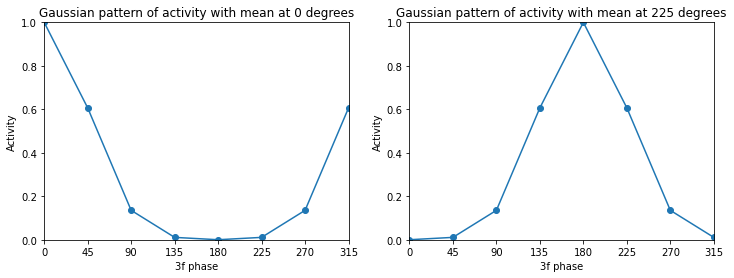

In [5]:
A, B = gabor_stimuli()
#Plot examples of stimuli at 0deg and 225deg
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.set_xlabel('3f phase')
ax2.set_xlabel('3f phase')
ax1.set_title('Gaussian pattern of activity with mean at 0 degrees')
ax2.set_title('Gaussian pattern of activity with mean at 225 degrees')
ax1.set_ylabel('Activity')
ax2.set_ylabel('Activity')
ax1.set_xlim((0, 1))
ax2.set_xlim((0, 1))
ax1.set_ylim((0, 1))
ax2.set_ylim((0, 1))
ax1.set_xticks(np.arange(0, 360, 45))
ax2.set_xticks(np.arange(0, 360, 45))
ax1.plot(np.arange(0, 360, 45), B[0][:8],'o-')
ax2.plot(np.arange(0, 360, 45), A[2][:8],'o-')
plt.savefig('Input examplars.png')



In [6]:
def test_model(lVF, rVF, trials, stimuli, labels):
    left_resp = np.zeros((7, 8, 3, trials))
    right_resp = np.zeros((7, 8, 3, trials))
    for t in range(trials):
        for i, s in enumerate(stimuli):
            y_l = lVF.activation(s, 0)
            y_r = rVF.activation(s, 0)
                
            left_resp[:,i, 0,t] = y_l
            right_resp[:,i, 0,t] = y_r
            
            y_l = lVF.activation(y_l, 1)
            y_r = rVF.activation(y_r, 1)
            
            left_resp[:,i, 1,t] = y_l
            right_resp[:,i, 1,t] = y_r
            
            y_l = lVF.activation(y_l, 2, cat_input=labels[i])
            y_r = rVF.activation(y_r, 2, cat_input=labels[i])
            
            left_resp[:,i, 2, t] = y_l
            right_resp[:,i, 2, t] = y_r
    
    return left_resp, right_resp
    

def pre_train_model(lVF, rVF, epochs, A, B):
    #Generate pre-training sequence where 0 is left and 1 is right
    training_sequence = np.repeat([0,1], epochs/2)
    np.random.shuffle(training_sequence)
    pre_training_set = np.concatenate((A,B))
    zero_stim = np.zeros(9)
    for vf in training_sequence:
        np.random.shuffle(pre_training_set)
        for stim in pre_training_set:          
            if vf == 0:
                gets_stim = lVF
                no_stim = rVF
            else:
                gets_stim = rVF
                no_stim = lVF
            
            #Precortical for both visual fields
            y_stim0 = gets_stim.activation(stim, 0)
            y_no0 = no_stim.activation(zero_stim, 0)
            gets_stim.update(stim, 0)
            no_stim.update(zero_stim, 0)
            
            #Early cortical 
            y_stim1 = gets_stim.activation(y_stim0, 1)
            y_no1 = no_stim.activation(y_no0, 1) 
            gets_stim.update(y_stim0, 1)             
            no_stim.update(y_no0, 1)
            
            #Ventral visual 
            gets_stim.activation(y_stim1, 2)
            no_stim.activation(y_no1, 2)
            gets_stim.update(y_stim1, 2)
            no_stim.update(y_no1, 2)

def category_train(lVF, rVF, epochs, A, B):
    stim = np.concatenate((B[:2], A, B[2:]))
    a = [2,3,4,5]
    b = [0,1,6,7]
    #P_A = [90, 135, 180, 225]       
    #P_B = [0, 45, 270, 315]
    #a = [0, 2, 5, 7]
    #b = [1, 3, 4, 6]
    
    #labels = np.array([0,1,0,1,1,0,1,0])
    labels = np.array([1, 1, 0, 0, 0, 0, 1, 1])
    
    within_A = np.array(list(itertools.permutations(a, 2)))
    within_B = np.array(list(itertools.permutations(b, 2)))
    all_within = np.concatenate((within_A, within_B))
    between = np.array(list(itertools.permutations(np.arange(0, 8, 1), 2)))
    between = between[np.all(np.any((between-all_within[:, None]), axis=2), axis=0)]
    stim_ind = np.concatenate((all_within, between))
    
    
    
    #Double training sequence
    random_sequence_stim = np.arange(0, 56, 1)
    
    
    #Single training sequence
    random_sequence_vf = np.repeat([0,1], 4)
    np.random.shuffle(random_sequence_vf)
    random_sequence_stim2 = np.arange(0, 8, 1)
    
    
    zero_stim = np.zeros(9)
    for e in range(epochs):
        np.random.shuffle(random_sequence_stim)
        np.random.shuffle(random_sequence_stim2)
        
        #Double training
        for i in random_sequence_stim:
            s = stim_ind[i]
            s_left = stim[s[0]]
            s_right = stim[s[1]]
            l_left = labels[s[0]]
            l_right = labels[s[1]]
            
            #Precortical for both visual fields
            y_l = lVF.activation(s_left, 0)
            y_r = rVF.activation(s_right, 0)
            lVF.update(s_left, 0)
            rVF.update(s_right, 0)
            
            #Early cortical 
            y_l = lVF.activation(y_l, 1)
            y_r = rVF.activation(y_r, 1) 
            lVF.update(y_l, 1)             
            rVF.update(y_r, 1)
            
            #Ventral visual 
            lVF.activation(y_l, 2, cat_input=l_left)
            rVF.activation(y_r, 2, cat_input=l_right)
            lVF.update(y_l, 2, cat_input=l_left, category_training=True)
            rVF.update(y_r, 2, cat_input=l_right, category_training=True)
        
        #Single training
        for i in range(3):
            for j in range(8):                
                if random_sequence_vf[j] == 0:
                    gets_stim = lVF
                    no_stim = rVF
                else:
                    gets_stim = rVF
                    no_stim = lVF
                s = random_sequence_stim2[j]

                s_stim = stim[s]
                l_stim = labels[s]
                #Precortical for both visual fields
                y_stim = gets_stim.activation(s_stim, 0)
                y_zero = no_stim.activation(zero_stim, 0)
                gets_stim.update(s_stim, 0)
                no_stim.update(zero_stim, 0)

                #Early cortical 
                y_stim = gets_stim.activation(y_stim, 1)
                y_zero = no_stim.activation(y_zero, 1) 
                gets_stim.update(y_stim, 1)             
                no_stim.update(y_zero, 1)

                #Ventral visual 
                gets_stim.activation(y_stim, 2, cat_input=l_stim)
                no_stim.activation(y_zero, 2)
                gets_stim.update(y_stim, 2, cat_input=l_stim, category_training=True)
                no_stim.update(y_zero, 2)


In [231]:
def simulation_trial(num_trials, pre_epochs, cat_epochs, test_trials, o=45):
    data = []
    A, B = gabor_stimuli()
    A_shift, B_shift = gabor_stimuli(o)
    test_set = np.concatenate((B_shift[:2], A_shift, B_shift[2:]))
    labels0 = np.repeat(0, 8)
    #labels1 = np.array([0,1,0,1,1,0,1,0])
    labels1 = np.array([1, 1, 0, 0, 0, 0, 1, 1])
    for trial in range(num_trials):
        lVF = model()
        rVF = model()       
        left_resp_rand, right_resp_rand = test_model(lVF, rVF, test_trials, test_set, labels0)
        pre_train_model(lVF, rVF, pre_epochs, A, B)
        left_resp_pre_train, right_resp_pre_train = test_model(lVF, rVF, test_trials, test_set, labels0)
        category_train(lVF, rVF, cat_epochs, A, B)
        left_resp_cat_train, right_resp_cat_train = test_model(lVF, rVF, test_trials, test_set, labels1)
        trial_data = [left_resp_rand, right_resp_rand, left_resp_pre_train, right_resp_pre_train, left_resp_cat_train, right_resp_cat_train]
    data.append(trial_data)    
    return data

In [232]:
data = np.array(simulation_trial(1, 25, 10, 1, o=30))

In [233]:
left_resp_rand = data[0,0,:,:,:,0]
right_resp_rand = data[0,1,:,:,:,0]
left_resp_pre_train = data[0,2,:,:,:,0]
right_resp_pre_train = data[0,3,:,:,:,0]
left_resp_cat_train = data[0,4,:,:,:,0]
right_resp_cat_train = data[0,5,:,:,:,0]

left_resp_cat_train.shape

(7, 8, 3)

<ipython-input-234-d8b5900489c2>:33: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([a,b,c,d,e,f,g], labels=labels, loc="right")


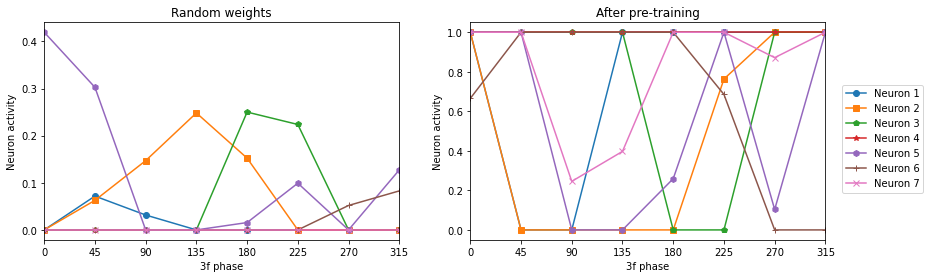

In [234]:
#Plot left PC before pre-cat training and after
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
ax1.set_xlabel('3f phase')
ax2.set_xlabel('3f phase')
ax1.set_title('Random weights')
ax2.set_title('After pre-training')
ax1.set_ylabel('Neuron activity')
ax2.set_ylabel('Neuron activity')
#ax1.set_ylim((-1, 1))
#ax2.set_ylim((-1, 1))
ax1.set_xlim((0, 315))
ax2.set_xlim((0, 315))
ax1.set_xticks(np.arange(0, 360, 45))
ax2.set_xticks(np.arange(0, 360, 45))

a=ax1.plot(np.arange(0, 360, 45), left_resp_rand[0,:,0], 'o-')
b=ax1.plot(np.arange(0, 360, 45), left_resp_rand[1,:,0], 's-')
c=ax1.plot(np.arange(0, 360, 45), left_resp_rand[2,:,0], 'p-')
d=ax1.plot(np.arange(0, 360, 45), left_resp_rand[3,:,0], '*-')
e=ax1.plot(np.arange(0, 360, 45), left_resp_rand[4,:,0], 'h-')
f=ax1.plot(np.arange(0, 360, 45), left_resp_rand[5,:,0], '+-')
g=ax1.plot(np.arange(0, 360, 45), left_resp_rand[6,:,0], 'x-')

ax2.plot(np.arange(0, 360, 45), left_resp_pre_train[0,:,0], 'o-')
ax2.plot(np.arange(0, 360, 45), left_resp_pre_train[1,:,0], 's-')
ax2.plot(np.arange(0, 360, 45), left_resp_pre_train[2,:,0], 'p-')
ax2.plot(np.arange(0, 360, 45), left_resp_pre_train[3,:,0], '*-')
ax2.plot(np.arange(0, 360, 45), left_resp_pre_train[4,:,0], 'h-')
ax2.plot(np.arange(0, 360, 45), left_resp_pre_train[5,:,0], '+-')
ax2.plot(np.arange(0, 360, 45), left_resp_pre_train[6,:,0], 'x-')

labels = ['Neuron 1', 'Neuron 2', 'Neuron 3', 'Neuron 4', 'Neuron 5', 'Neuron 6', 'Neuron 7'] 
fig.legend([a,b,c,d,e,f,g], labels=labels, loc="right")
plt.savefig('Pretraining-PC.png')
plt.show()


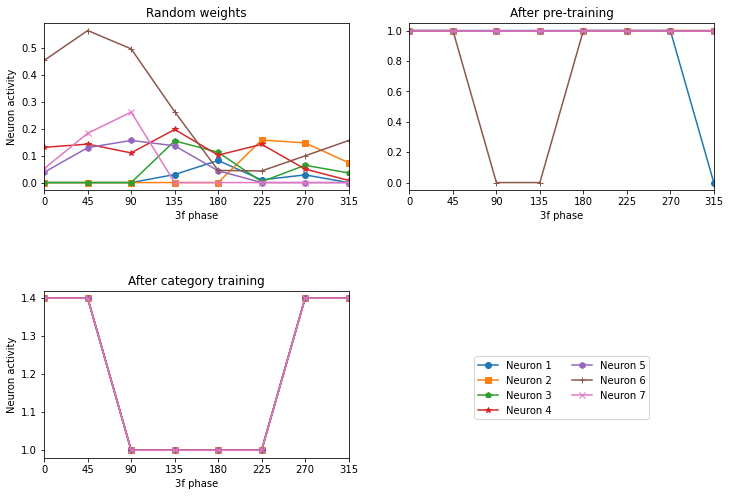

In [235]:
fig2 = plt.figure(constrained_layout=False, figsize=(12,8))
gs = fig2.add_gridspec(2,2)
ax1 = fig2.add_subplot(gs[0, 0])
ax2 = fig2.add_subplot(gs[0, 1:])
ax3 = fig2.add_subplot(gs[1:, 0])

ax1.set_xlabel('3f phase')
ax2.set_xlabel('3f phase')
ax3.set_xlabel('3f phase')
ax1.set_title('Random weights')
ax2.set_title('After pre-training')
ax3.set_title('After category training')
ax1.set_ylabel('Neuron activity')
ax3.set_ylabel('Neuron activity')
ax1.set_xlim((0, 315))
ax2.set_xlim((0, 315))
ax3.set_xlim((0, 315))
ax1.set_xticks(np.arange(0, 360, 45))
ax2.set_xticks(np.arange(0, 360, 45))
ax3.set_xticks(np.arange(0, 360, 45))

ax1.plot(np.arange(0, 360, 45), right_resp_rand[0,:,2], 'o-')
ax1.plot(np.arange(0, 360, 45), right_resp_rand[1,:,2], 's-')
ax1.plot(np.arange(0, 360, 45), right_resp_rand[2,:,2], 'p-')
ax1.plot(np.arange(0, 360, 45), right_resp_rand[3,:,2], '*-')
ax1.plot(np.arange(0, 360, 45), right_resp_rand[4,:,2], 'h-')
ax1.plot(np.arange(0, 360, 45), right_resp_rand[5,:,2], '+-')
ax1.plot(np.arange(0, 360, 45), right_resp_rand[6,:,2], 'x-')

ax2.plot(np.arange(0, 360, 45), right_resp_pre_train[0,:,2], 'o-')
ax2.plot(np.arange(0, 360, 45), right_resp_pre_train[1,:,2], 's-')
ax2.plot(np.arange(0, 360, 45), right_resp_pre_train[2,:,2], 'p-')
ax2.plot(np.arange(0, 360, 45), right_resp_pre_train[3,:,2], '*-')
ax2.plot(np.arange(0, 360, 45), right_resp_pre_train[4,:,2], 'h-')
ax2.plot(np.arange(0, 360, 45), right_resp_pre_train[5,:,2], '+-')
ax2.plot(np.arange(0, 360, 45), right_resp_pre_train[6,:,2], 'x-')

a=ax3.plot(np.arange(0, 360, 45), right_resp_cat_train[0,:,2], 'o-')
b=ax3.plot(np.arange(0, 360, 45), right_resp_cat_train[1,:,2], 's-')
c=ax3.plot(np.arange(0, 360, 45), right_resp_cat_train[2,:,2], 'p-')
d=ax3.plot(np.arange(0, 360, 45), right_resp_cat_train[3,:,2], '*-')
e=ax3.plot(np.arange(0, 360, 45), right_resp_cat_train[4,:,2], 'h-')
g=ax3.plot(np.arange(0, 360, 45), right_resp_cat_train[5,:,2], '+-')
h=ax3.plot(np.arange(0, 360, 45), right_resp_cat_train[6,:,2], 'x-')

labels = ['Neuron 1', 'Neuron 2', 'Neuron 3', 'Neuron 4', 'Neuron 5', 'Neuron 6', 'Neuron 7'] 
ax2.legend(labels, loc='lower center', bbox_to_anchor=(0.5, -1.4), ncol= 2)
plt.subplots_adjust(hspace=0.6)
plt.savefig('VV.png')
plt.show()

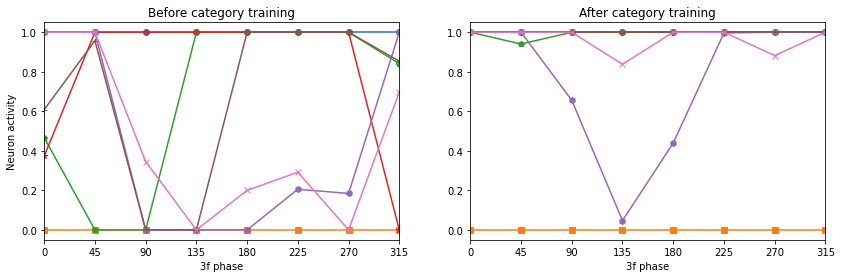

In [228]:
#Plot right PC before cat training and after
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
ax1.set_xlabel('3f phase')
ax2.set_xlabel('3f phase')
ax1.set_title('Before category training')
ax2.set_title('After category training')
ax1.set_ylabel('Neuron activity')
#ax1.set_ylim((-1, 1))
#ax2.set_ylim((-1, 1))
ax1.set_xlim((0, 315))
ax2.set_xlim((0, 315))
ax1.set_xticks(np.arange(0, 360, 45))
ax2.set_xticks(np.arange(0, 360, 45))

ax1.plot(np.arange(0, 360, 45), left_resp_pre_train[0,:,0], 'o-')
ax1.plot(np.arange(0, 360, 45), left_resp_pre_train[1,:,0], 's-')
ax1.plot(np.arange(0, 360, 45), left_resp_pre_train[2,:,0], 'p-')
ax1.plot(np.arange(0, 360, 45), left_resp_pre_train[3,:,0], '*-')
ax1.plot(np.arange(0, 360, 45), left_resp_pre_train[4,:,0], 'h-')
ax1.plot(np.arange(0, 360, 45), left_resp_pre_train[5,:,0], '+-')
ax1.plot(np.arange(0, 360, 45), left_resp_pre_train[6,:,0], 'x-')

ax2.plot(np.arange(0, 360, 45), left_resp_cat_train[0,:,0], 'o-')
ax2.plot(np.arange(0, 360, 45), left_resp_cat_train[1,:,0], 's-')
ax2.plot(np.arange(0, 360, 45), left_resp_cat_train[2,:,0], 'p-')
ax2.plot(np.arange(0, 360, 45), left_resp_cat_train[3,:,0], '*-')
ax2.plot(np.arange(0, 360, 45), left_resp_cat_train[4,:,0], 'h-')
ax2.plot(np.arange(0, 360, 45), left_resp_cat_train[5,:,0], '+-')
ax2.plot(np.arange(0, 360, 45), left_resp_cat_train[6,:,0], 'x-')

plt.show()

In [117]:
def calculate_CP(lVF, rVF, A, B, delta=0.2, within=True, cat=False):
    stim = np.concatenate((B[:2], A, B[2:]))
    a = [2,3,4,5]
    b = [0,1,6,7]
    within_A = np.array(list(itertools.permutations(a, 2)))
    within_B = np.array(list(itertools.permutations(b, 2)))
    all_within = np.concatenate((within_A, within_B))
    
    if within:
        stim_ind = all_within
    else:
        between = np.array(list(itertools.permutations(np.arange(0, 8, 1), 2)))
        between = between[np.all(np.any((between-all_within[:, None]), axis=2), axis=0)]
        stim_ind = between

    if cat:
        labels = np.array([1,1,0,0,0,0,1,1])
    else:
        labels = np.repeat(0, 8)
    
    #Testing sequence
    if within:
        random_sequence_stim = np.arange(0, 24, 1)      
        total = 24
    else:
        random_sequence_stim = np.arange(0, 32, 1)
        total = 32
    
    np.random.shuffle(random_sequence_stim)
    
    Hits = np.zeros(3)
    False_alarm = np.zeros(3)
    
    #Testing
    for i in random_sequence_stim:
        s = stim_ind[i]
        s_left = stim[s[0]]
        s_right = stim[s[1]]
        l_left = labels[s[0]]
        l_right = labels[s[1]]

        #Precortical for both visual fields
        y_l = lVF.activation(s_left, 0)
        y_r = rVF.activation(s_right, 0)
        #Check if H or F
#         sum_y_l = np.sum(y_l)
#         sum_y_r = np.sum(y_r)
#         max_y_l = np.amax(y_l)
#         max_y_r = np.amax(y_r)
#         min_y_l = np.amin(y_l)
#         min_y_r = np.amin(y_r)
        
#         Y_l = (sum_y_l - min_y_l)/(max_y_l - min_y_l)
#         Y_r = (sum_y_r - min_y_r)/(max_y_r - min_y_r)

        Y_l = np.sum(y_l)
        Y_r = np.sum(y_r)

        Y_l = np.sum(minmax_scale(y_l))
        Y_r = np.sum(minmax_scale(y_r))
        
        if math.fabs(Y_l - Y_r) > delta:
            Hits[0] += 1
        else:
            False_alarm[0] += 1
        

        #Early cortical 
        y_l = lVF.activation(y_l, 1)
        y_r = rVF.activation(y_r, 1) 
        
        #Check if H or F
#         sum_y_l = np.sum(y_l)
#         sum_y_r = np.sum(y_r)
#         max_y_l = np.amax(y_l)
#         max_y_r = np.amax(y_r)
#         min_y_l = np.amin(y_l)
#         min_y_r = np.amin(y_r)
        
#         Y_l = (sum_y_l - min_y_l)/(max_y_l - min_y_l)
#         Y_r = (sum_y_r - min_y_r)/(max_y_r - min_y_r)
        
        Y_l = np.sum(y_l)
        Y_r = np.sum(y_r)

#         Y_l = np.sum(minmax_scale(y_l))
#         Y_r = np.sum(minmax_scale(y_r))
        
        if math.fabs(Y_l - Y_r) > delta:
            Hits[1] += 1
        else:
            False_alarm[1] += 1
        

        #Ventral visual 
        y_l = lVF.activation(y_l, 2, cat_input=l_left)
        y_r = rVF.activation(y_r, 2, cat_input=l_right)
        
        #Check if H or F
#         sum_y_l = np.sum(y_l)
#         sum_y_r = np.sum(y_r)
#         max_y_l = np.amax(y_l)
#         max_y_r = np.amax(y_r)
#         min_y_l = np.amin(y_l)
#         min_y_r = np.amin(y_r)
        
#         Y_l = (sum_y_l - min_y_l)/(max_y_l - min_y_l)
#         Y_r = (sum_y_r - min_y_r)/(max_y_r - min_y_r)

        Y_l = np.sum(y_l)
        Y_r = np.sum(y_r)

#         Y_l = np.sum(minmax_scale(y_l))
#         Y_r = np.sum(minmax_scale(y_r))
        
        if math.fabs(Y_l - Y_r) > delta:
            Hits[2] += 1
        else:
            False_alarm[2] += 1
        
    return Hits/total, False_alarm/total

def A_score(H, F):
    if H < F:
        return 1/2
    else:
        return 1/2 + ((H-F)*(1+H-F))/(4*H*(1-F))

In [236]:
def experiment(pre_epochs, cat_epochs, trials=50, o=45):
    #Trials*layers*phases
    A_w = np.zeros((trials, 3, 2))
    A_b = np.zeros((trials, 3, 2))
    A, B = gabor_stimuli()
    A_sh, B_sh = gabor_stimuli(o)
    for i in range(trials):
        lVF = model()
        rVF = model()
        
#         #Within
#         Hw, Fw = calculate_CP(lVF, rVF, A, B, cat=False) 
#         A_w[i, 0, 0] = A_score(Hw[0], Fw[0])
#         A_w[i, 1, 0] = A_score(Hw[1], Fw[1])
#         A_w[i, 2, 0] = A_score(Hw[2], Fw[2])
        
#         #Between 
#         Hb, Fb = calculate_CP(lVF, rVF, A, B, within=False, cat=False)
#         A_b[i, 0, 0] = A_score(Hb[0], Fb[0])
#         A_b[i, 1, 0] = A_score(Hb[1], Fb[1])
#         A_b[i, 2, 0] = A_score(Hb[2], Fb[2])
        
        pre_train_model(lVF, rVF, pre_epochs, A, B)
        
        #Within
        Hw, Fw = calculate_CP(lVF, rVF, A_sh, B_sh, cat=False) 
        A_w[i, 0, 0] = A_score(Hw[0], Fw[0])
        A_w[i, 1, 0] = A_score(Hw[1], Fw[1])
        A_w[i, 2, 0] = A_score(Hw[2], Fw[2])
        
        #Between 
        Hb, Fb = calculate_CP(lVF, rVF, A_sh, B_sh, within=False, cat=False)
        A_b[i, 0, 0] = A_score(Hb[0], Fb[0])
        A_b[i, 1, 0] = A_score(Hb[1], Fb[1])
        A_b[i, 2, 0] = A_score(Hb[2], Fb[2])
        
        category_train(lVF, rVF, cat_epochs, A, B)
        
        #Within
        Hw, Fw = calculate_CP(lVF, rVF, A_sh, B_sh, cat=True)   
        A_w[i, 0, 1] = A_score(Hw[0], Fw[0])
        A_w[i, 1, 1] = A_score(Hw[1], Fw[1])
        A_w[i, 2, 1] = A_score(Hw[2], Fw[2])
        
        #Between 
        Hb, Fb = calculate_CP(lVF, rVF, A_sh, B_sh, within=False, cat=True)
        A_b[i, 0, 1] = A_score(Hb[0], Fb[0])
        A_b[i, 1, 1] = A_score(Hb[1], Fb[1])
        A_b[i, 2, 1] = A_score(Hb[2], Fb[2])
    return A_w, A_b

# Running the experiment

In [238]:
A_w, A_b = experiment(25, 10, trials=50)                                                                                                                                      

In [239]:
mean_A_W = np.mean(A_w, axis=0)
mean_A_B = np.mean(A_b, axis=0)
print("VV-BEFORE: A'(W): {} and A'(B): {}".format(mean_A_W[2][0], mean_A_B[2][0]))
print("VV-AFTER: A'(W): {} and A'(B): {}".format(mean_A_W[2][1], mean_A_B[2][1]))
print("EC-BEFORE: A'(W): {} and A'(B): {}".format(mean_A_W[1][0], mean_A_B[1][0]))
print("EC-AFTER: A'(W): {} and A'(B): {}".format(mean_A_W[1][1], mean_A_B[1][1]))
print("PC-BEFORE: A'(W): {} and A'(B): {}".format(mean_A_W[0][0], mean_A_B[0][0]))
print("PC-AFTER: A'(W): {} and A'(B): {}".format(mean_A_W[0][1], mean_A_B[0][1]))

VV-BEFORE: A'(W): 0.9648002790048825 and A'(B): 0.9629812512704617
VV-AFTER: A'(W): 0.9141968751847608 and A'(B): 0.9930278086763074
EC-BEFORE: A'(W): 0.8016816987920773 and A'(B): 0.8055561944911367
EC-AFTER: A'(W): 0.6059019267626077 and A'(B): 0.6098936080220166
PC-BEFORE: A'(W): 0.89606150752375 and A'(B): 0.9056780942761692
PC-AFTER: A'(W): 0.9260864310903345 and A'(B): 0.9324315113859827


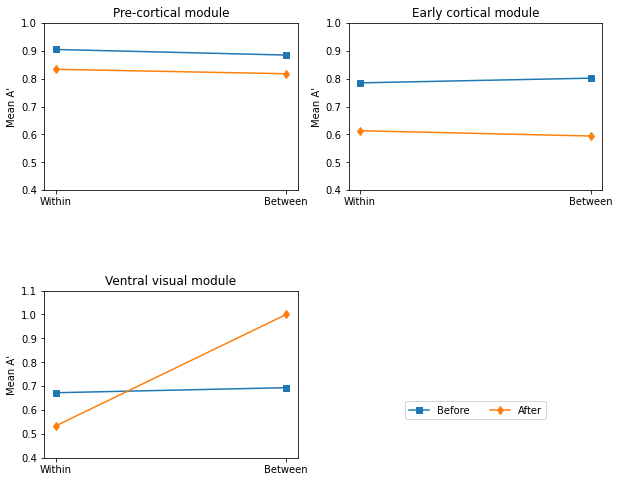

In [207]:
fig2 = plt.figure(constrained_layout=False, figsize=(10,8))
gs = fig2.add_gridspec(2,2)
ax1 = fig2.add_subplot(gs[0, 0])
ax2 = fig2.add_subplot(gs[0, 1:])
ax3 = fig2.add_subplot(gs[1:, 0])

labels = ['Within', 'Between']
intervals = [1, 1.5]
ax1.set_ylabel("Mean A'")
ax1.xaxis.set_major_locator(FixedLocator(intervals))
ax1.xaxis.set_major_formatter(FixedFormatter(labels))
ax1.plot(intervals, [mean_A_W[0][0], mean_A_B[0][0]], 's-')
ax1.plot(intervals, [mean_A_W[0][1], mean_A_B[0][1]], 'd-' )
ax1.set_ylim(0.4, 1)

ax2.set_ylabel("Mean A'")
ax2.xaxis.set_major_locator(FixedLocator(intervals))
ax2.xaxis.set_major_formatter(FixedFormatter(labels))
ax2.plot(intervals, [mean_A_W[1][0], mean_A_B[1][0]], 's-')
ax2.plot(intervals, [mean_A_W[1][1], mean_A_B[1][1]], 'd-' )
ax2.set_ylim(0.4, 1)

ax3.set_ylabel("Mean A'")
ax3.xaxis.set_major_locator(FixedLocator(intervals))
ax3.xaxis.set_major_formatter(FixedFormatter(labels))
ax3.plot(intervals, [mean_A_W[2][0], mean_A_B[2][0]], 's-')
ax3.plot(intervals, [mean_A_W[2][1], mean_A_B[2][1]], 'd-')
ax3.set_ylim(0.4, 1.1)

ax1.set_title("Pre-cortical module")
ax2.set_title("Early cortical module")
ax3.set_title("Ventral visual module")

labels = ['Before', 'After'] 
ax2.legend(labels, loc='lower center', bbox_to_anchor=(0.5, -1.4), ncol= 2)
plt.subplots_adjust(hspace=0.6)
plt.savefig('results.png')

In [187]:
stats.ttest_ind(A_b[:, 2, 0], A_b[:, 2, 1], equal_var=False)

Ttest_indResult(statistic=-18.155235702970472, pvalue=2.8543211120988175e-33)

In [186]:
stats.ttest_ind(A_w[:, 2, 0], A_w[:, 2, 1], equal_var=False)

Ttest_indResult(statistic=8.20780770919575, pvalue=2.53044337264005e-13)

In [189]:
stats.ttest_ind(A_w[:, 0, 0], A_w[:, 0, 1], equal_var=False)

Ttest_indResult(statistic=5.454846154186945, pvalue=2.0577549298161877e-07)

In [188]:
stats.ttest_ind(A_b[:, 0, 0], A_b[:, 0, 1], equal_var=False)

Ttest_indResult(statistic=4.696683049525964, pvalue=5.6344755609791805e-06)

In [191]:
stats.ttest_ind(A_w[:, 1, 0], A_w[:, 1, 1], equal_var=False)

Ttest_indResult(statistic=12.250095357883279, pvalue=5.708091980944814e-26)

In [190]:
stats.ttest_ind(A_b[:, 1, 0], A_b[:, 1, 1], equal_var=False)

Ttest_indResult(statistic=11.206170345887946, pvalue=6.890865745043516e-23)

In [241]:
O = [0, 15, 30, 40, 43, 45, 47, 50, 60, 75, 90]
diff_A_w = np.zeros(len(O))
diff_A_b = np.zeros(len(O))

for i, o in enumerate(O):
    A_w, A_b = experiment(25, 10, trials=50, o=o)
    mean_A_W = np.mean(A_w, axis=0)
    mean_A_B = np.mean(A_b, axis=0)
    diff_A_w[i] = mean_A_W[2][1] - mean_A_W[2][0]
    diff_A_b[i] = mean_A_B[2][1] - mean_A_B[2][0]

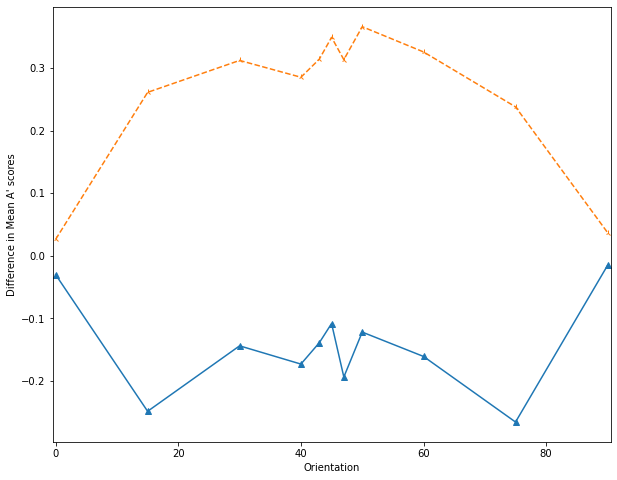

In [254]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([-0.5, 90.5])
ax.plot(O, diff_A_w, '^-')
ax.plot(O, diff_A_b, '2--')
ax.set_ylabel("Difference in Mean A' scores")
ax.set_xlabel("Orientation")

plt.savefig('orientation-gen.png')